
## e-Sensing: Big Earth observation data analytics for land use and land cover change information

The e-Sensing project aims to conceive, build and deploy a knowledge platform for organizing, accessing, processing and analysing big Earth Observation data. The São Paulo Research Foundation (FAPESP) funded this project for four years (2015-2018).

<br>
<center>
<table align="center">
<tr>
<td>
<img src="img/conceptual.png" alt="e-Sensing conceptual view" width=750> 
</td>
</tr>
</table>
</center>

## The architecture
This is the conceptual view of our architecture:
- __R__ analytics
- array databases
- web services of time series of images

<br>
<br>
<center>
<table align="center">
<tr>
<td>
<img src="img/achicteture_esensing.png" alt="e-Sensing architecture" width=750> 
</td>
</tr>
</table>
</center>


## Matching requirements to architecture


<br>
<center>
<table align="center">
<tr>
<td>
<img src="img/match1.png" alt="e-Sensing architecture" width=850> 
</td>
</tr>
</table>
</center>


## Matching requirements to architecture


<br>
<center>
<table align="center">
<tr>
<td>
<img src="img/match2.png" alt="e-Sensing architecture" width=850> 
</td>
</tr>
</table>
</center>

## The e-Sensing data cube 
Our approach is based on data cubes which provide time series of EO data to be analyzed using the "time-first space-later" approach. This approach is so far unavaliable in other open platforms.

<table align="center">
<tr>
<td>
<img src="img/timefirst.png" alt="time-first, space-later" width=750></td>
</tr>
</table>

In this demonstration, we use a Jupyter Notebook and R scripts to show you some interesting results.

## WTSS - Web Time Series Service ##

Our architecture includes a lightweight JSON web service to access our data cubes. This service has three simple, but well defined, capabilities:
1. *list* the coverages available in a data cube
2. *describe* a coverage
3. *retrieve* time series from a coverage at a given location.

We have a WTSS server running at INPE. We show next how to use a WTSS __R__ client, and how to integrate it with other __R__ packages.

In [1]:
# Load the WTSS R client
library(wtss)

# Connect to the server
ts.server <- WTSS("http://www.dpi.inpe.br/tws/wtss")

# Retrieve the coverages
coverages <- listCoverages(ts.server)

# Display the result
coverages

[1] "itobi"       "merge"       "mixl8mod"    "mixl8mod_f"  "mod13q1_512"

In [2]:
# Select and examine a coverage
coverage.name <- "mod13q1_512"
cv_scheme =  describeCoverage(ts.server, coverage.name)
cv_scheme[[names(cv_scheme)]]

$name
[1] "mod13q1_512"

$description
[1] "Vegetation Indices 16-Day L3 Global 250m"

$detail
[1] "https://lpdaac.usgs.gov/dataset_discovery/modis/modis_products_table/mod13q1"

$dimensions
$dimensions$x
$dimensions$x$name
[1] "col_id"

$dimensions$x$min_idx
[1] 0

$dimensions$x$max_idx
[1] 172799


$dimensions$y
$dimensions$y$name
[1] "row_id"

$dimensions$y$min_idx
[1] 0

$dimensions$y$max_idx
[1] 86399


$dimensions$t
$dimensions$t$name
[1] "time_id"

$dimensions$t$min_idx
[1] 0

$dimensions$t$max_idx
[1] 376



$attributes
  name                            description datatype valid_range.min
1 ndvi                      250m 16 days NDVI    int16           -2000
2  evi                       250m 16 days EVI    int16           -2000
3  red  250m 16 days red reflectance (Band 1)    int16               0
4  nir  250m 16 days NIR reflectance (Band 2)    int16               0
5 blue 250m 16 days blue reflectance (Band 3)    int16               0
6  mir  250m 16 days MIR reflectance (Ban

Loading required package: ggplot2
Map from URL : http://maps.googleapis.com/maps/api/staticmap?center=BRAZIL&zoom=5&size=640x640&scale=2&maptype=terrain&language=en-EN&sensor=false
Information from URL : http://maps.googleapis.com/maps/api/geocode/json?address=BRAZIL&sensor=false


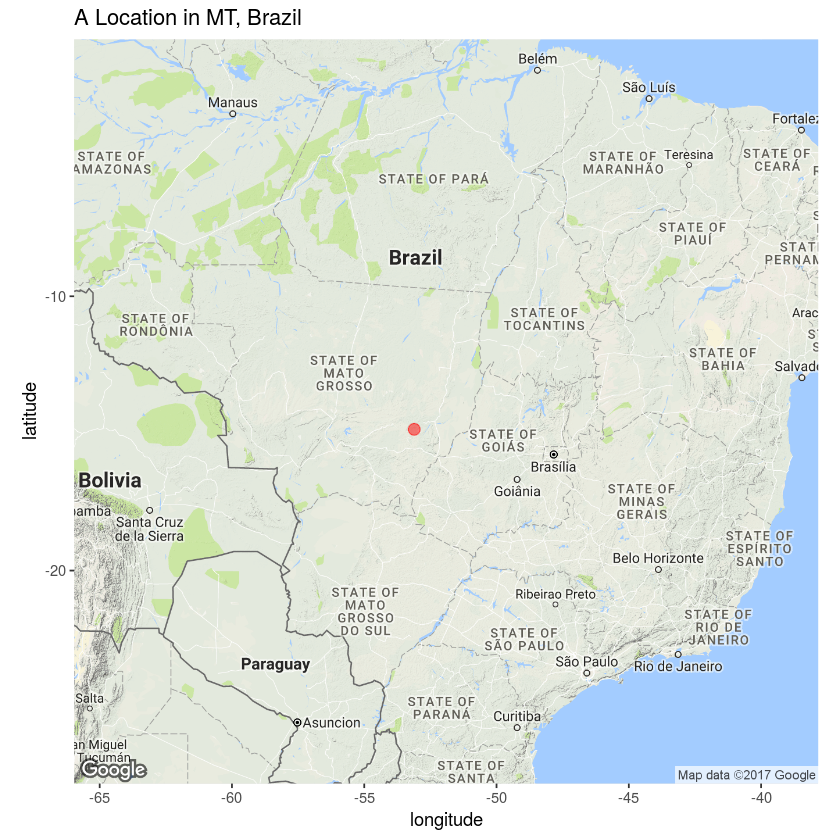

In [3]:
# Select a location of interest
long <- -53.11
lat <- -14.91

library(ggmap)
points <- data.frame(lon = long, lat = lat)

map <- get_map(location = "BRAZIL", zoom = 5)

ggmap(map) + 
  geom_point(data=points,color="red", size=3
             , alpha=0.5) + labs(x = "longitude", y = "latitude", title = "A Location in MT, Brazil")

In [4]:
# Recover the time series of this coverage (all attributes) in a given period, in the selected location
attributes <- cv_scheme[[names(cv_scheme)]]$attributes$name

start <- "2000-02-18"
end <- "2017-02-18"
  
mod13q1_ts = timeSeries(object = ts.server, 
                coverages = coverage.name, 
                attributes = attributes, 
                latitude = lat, 
                longitude = long, 
                start = start, 
                end = end)

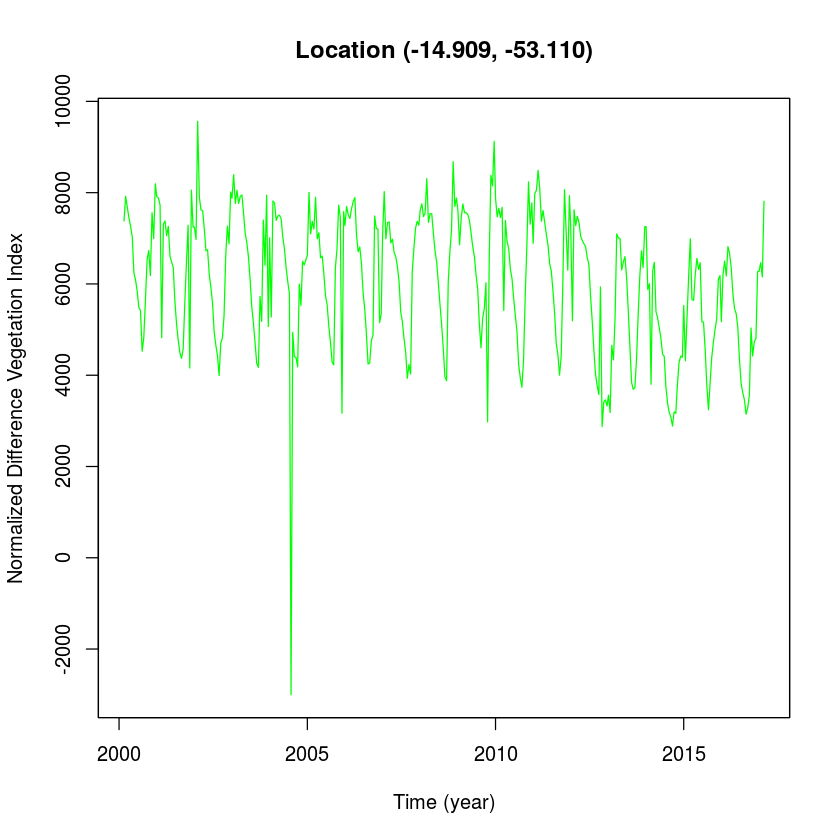

In [5]:
# Plotting the time series using R
plot(mod13q1_ts[[1]]$attributes[,1], 
     main=sprintf("Location (%5.3f, %5.3f)", 
                  mod13q1_ts[[1]]$center_coordinate$latitude, mod13q1_ts[[1]]$center_coordinate$longitude), 
     xlab="Time (year)", 
     ylab="Normalized Difference Vegetation Index", col="green", col.lab="black")

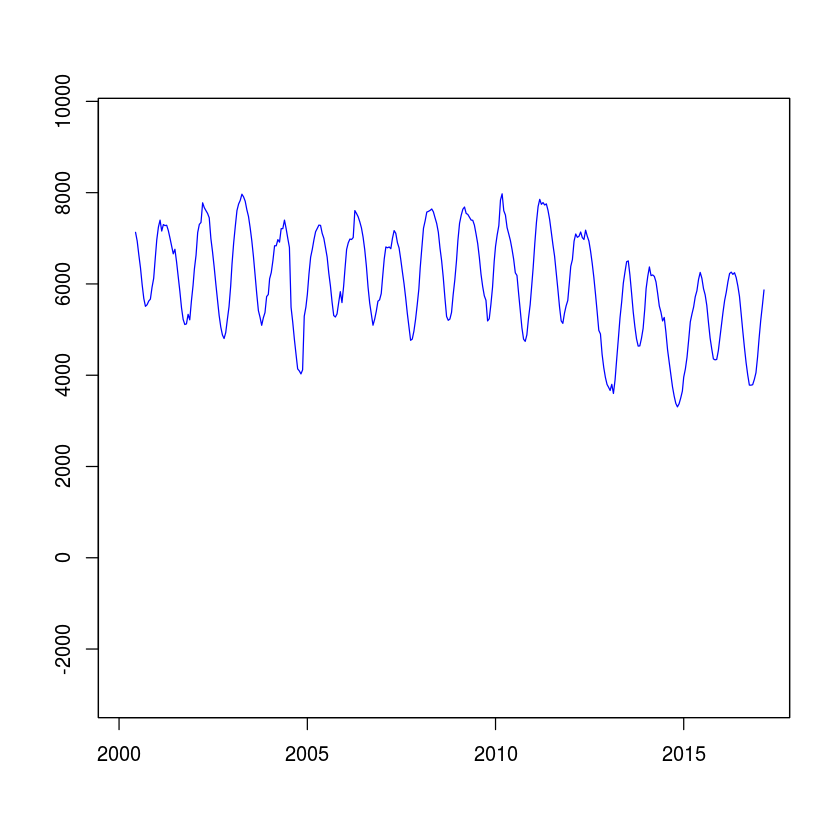

In [6]:
# Smoothing the time series with using a moving average methods (available in a third-party R package)
library("TTR")
smoothed_nvi <- SMA(mod13q1_ts[[1]]$attributes[,1],n=8)
plot(smoothed_nvi,ylim=range(mod13q1_ts[[1]]$attributes[,1]),xlab = "", ylab = "", col="blue")

## SITS - Satellite Image Time Series Analysis ##

A set of tools for working with satellite image time series. It uses WTSS, but is has many other specific features such as:
- supports image time series, for example retrieved from a data cube using WTSS;
- provides different visualisation methods specially designed for image time series;
- provides smoothing methods for noisy time series;
- provides a set of methods for image time series classifation, based on machine learning techiniques;
- classifies time series using machine learning techniques;

Next, we demonstrates SITS using examples.

In [7]:
# load SITS package
library(sits)

# connects to a WTSS server
URL <- "http://www.dpi.inpe.br/tws/wtss"
wtss_inpe <- sits_infoWTSS(URL)

# get information about a specific coverage
sits_coverageWTSS(URL,"mod13q1_512")


Loaded sits v0.9.17. See ?sits for help, citation("sits") for use in publication.

Registering TWDTW distance from `dtwSat` into `proxy::pr_DB`.



-----------------------------------------------------------
The WTSS server URL is http://www.dpi.inpe.br/tws/wtss
Available coverages: 
itobi
merge
mixl8mod
mixl8mod_f
mod13q1_512
------------------------------------------------------------
----------------------------------------------------------------------------------
Coverage: mod13q1_512
Description: Vegetation Indices 16-Day L3 Global 250m
Source: https://lpdaac.usgs.gov/dataset_discovery/modis/modis_products_table/mod13q1
Bands: 
  name                            description
1 ndvi                      250m 16 days NDVI
2  evi                       250m 16 days EVI
3  red  250m 16 days red reflectance (Band 1)
4  nir  250m 16 days NIR reflectance (Band 2)
5 blue 250m 16 days blue reflectance (Band 3)
6  mir  250m 16 days MIR reflectance (Band 7)

Spatial extent: (-180, -90) - (180, 90)
Spatial resolution: (0.00208334, 0.00208334)
Projection CRS: +proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs
Time range: 2000-02-18 to 2017-02

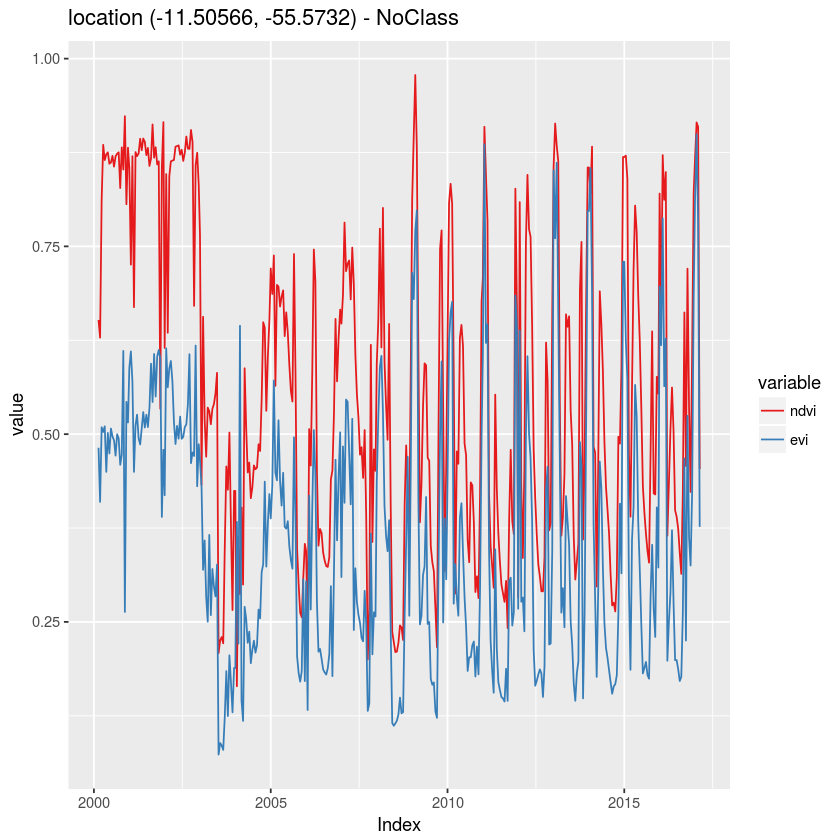

In [8]:
# choose a coverage
coverage <- "mod13q1_512"
# recover its bands
bands <- c("ndvi", "evi", "nir")
# define a location known as the transition forest pasture in Northern MT state in Brazil
long <- -55.57320
lat <- -11.50566

# obtain the time series from the WTSS server for this location
series.tb <- sits_getdata(longitude = long, latitude = lat, URL = URL, coverage = "mod13q1_512", bands = bands)

# plot the series
#sits_plot(series.tb) # all bands
sits_plot(sits_select(series.tb, bands = c("ndvi","evi")))


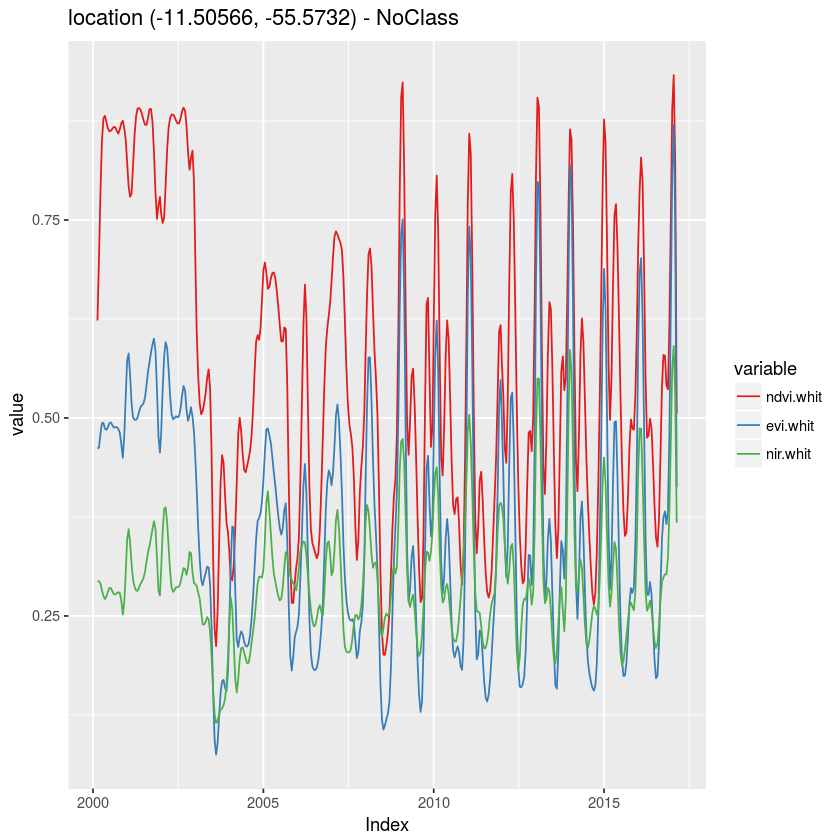

In [9]:
# filtering the series using the Whittaker filter implemented as part of SITS
series_fil.tb <- series.tb %>% 
  sits_whittaker(lambda=1)  

sits_plot(series_fil.tb) # all bands
#sits_plot(sits_select(series_fil.tb, bands = c("ndvi.whit", "evi.whit")))


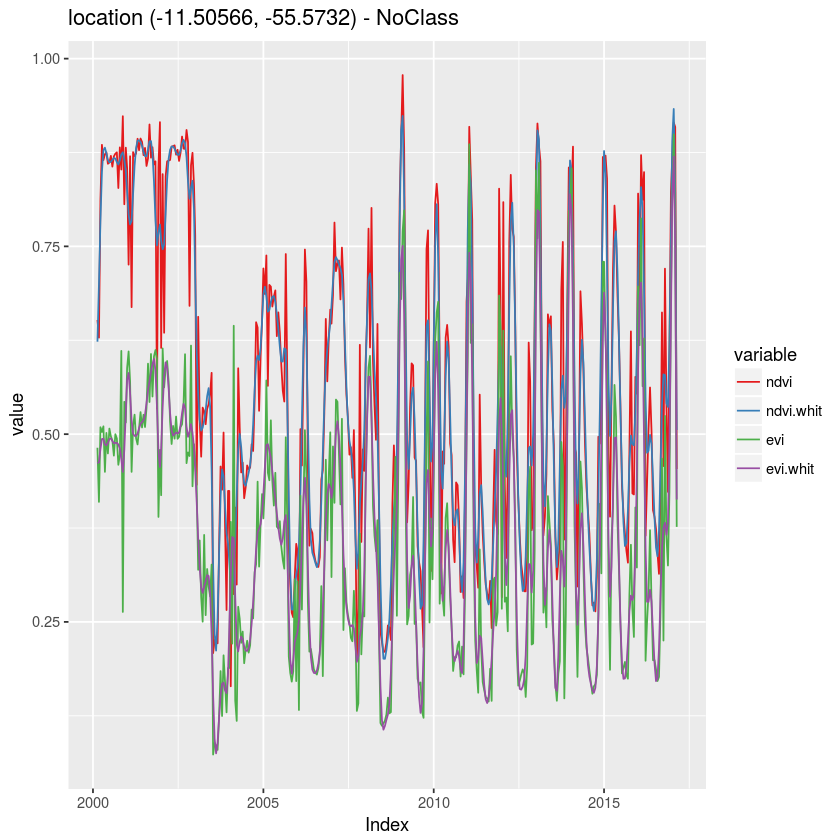

In [10]:
# plot two series.tb and series_fil.tb together by bands
series.tb %>% 
  sits_merge(series_fil.tb) %>% 
  sits_select(bands = c("ndvi","ndvi.whit","evi","evi.whit")) %>% 
  sits_plot()

## SITS - Satellite Image Time Series Analysis ##

In the next examples, we show how to classify a time series using the SITS package.

The SITS classification methods are based on machine learning techniques. These methods are unavailable in other large- scale processing platforms.

<table align="center">
<tr>
<td><img src="img/lucc.png" alt="land use patterns" width=750></td>
</tr>
</table>


## Temporal patterns of land use 

We start with a set of locations classified by experts using visual interpretation or field trips. This sample set associates a location and a time interval to a land cover. 

In the next example, we use samples collected ty the [Brazilian Agricultural Research Corporation (EMBRAPA)](https://www.embrapa.br/en/) in Mato Grosso state, Brazil. 

We use the WTSS to get time series of vegetation indexes at these locations for the time associated to the given land cover (we refer to this land cover simply as the "label").

In [11]:
# retrieve a set of samples from an RDS file
embrapa_mt.tb <- readRDS("data/embrapa_mt.rds")
embrapa_mt.tb

longitude latitude start_date end_date   label      coverage   
1    -55.1852  -10.8378 2013-09-14 2014-08-29 Pasture    mod13q1_512
2    -57.7940   -9.7573 2006-09-14 2007-08-29 Pasture    mod13q1_512
3    -51.9412  -13.4198 2014-09-14 2015-08-29 Pasture    mod13q1_512
4    -55.9643  -10.0621 2005-09-14 2006-08-29 Pasture    mod13q1_512
5    -54.5540  -10.3749 2013-09-14 2014-08-29 Pasture    mod13q1_512
6    -52.4572  -10.9512 2013-09-14 2014-08-29 Pasture    mod13q1_512
7    -52.1443  -13.9981 2013-09-14 2014-08-29 Pasture    mod13q1_512
8    -57.6907  -13.3382 2015-09-14 2016-08-28 Pasture    mod13q1_512
9    -54.7034  -16.4265 2015-09-14 2016-08-28 Pasture    mod13q1_512
10   -53.6543  -15.7155 2014-09-14 2015-08-29 Pasture    mod13q1_512
11   -56.7898  -11.4209 2011-09-14 2012-08-28 Pasture    mod13q1_512
12   -55.0254  -10.0669 2013-09-14 2014-08-29 Pasture    mod13q1_512
13   -55.2219  -15.6638 2015-09-14 2016-08-28 Pasture    mod13q1_512
14   -55.3344  -12.3212 2014-09-14 2015-08-29 Pasture    mod13q1_512
15   -52.4244  -15.8492 2013-09-14 2014-08-29 Pasture    mod13q1_512
16   -52.2960  -14.5021 2013-09-14 2014-08-29 Pasture    mod13q1_512
17   -56.4659  -14.3062 2014-09-14 2015-08-29 Pasture    mod13q1_512
18   -55.0574  -14.2136 2003-09-14 2004-08-28 Pasture    mod13q1_512
19   -54.3523  -15.7024 2015-09-14 2016-08-28 Pasture    mod13q1_512
20   -51.8127  -12.9071 2013-09-14 2014-08-29 Pasture    mod13q1_512
21   -59.0879  -15.2475 2002-09-14 2003-08-29 Pasture    mod13q1_512
22   -52.2846  -14.8633 2014-09-14 2015-08-29 Pasture    mod13q1_512
23   -55.3012  -11.2152 2013-09-14 2014-08-29 Pasture    mod13q1_512
24   -52.2087  -15.1112 2013-09-14 2014-08-29 Pasture    mod13q1_512
25   -51.8678  -12.9663 2013-09-14 2014-08-29 Pasture    mod13q1_512
26   -56.7898  -11.4209 2012-09-13 2013-08-29 Pasture    mod13q1_512
27   -52.3999  -11.1348 2013-09-14 2014-08-29 Pasture    mod13q1_512
28   -52.2933  -15.7941 2013-09-14 2014-08-29 Pasture    mod13q1_512
29   -54.5348  -16.5734 2015-09-14 2016-08-28 Pasture    mod13q1_512
30   -55.9323  -14.5852 2014-09-14 2015-08-29 Pasture    mod13q1_512
⋮    ⋮         ⋮        ⋮          ⋮          ⋮          ⋮          
2086 -57.9368  -13.4254 2006-09-14 2007-08-29 Soy_Fallow mod13q1_512
2087 -57.9368  -13.4235 2006-09-14 2007-08-29 Soy_Fallow mod13q1_512
2088 -57.9368  -13.4216 2006-09-14 2007-08-29 Soy_Fallow mod13q1_512
2089 -57.9368  -13.4197 2006-09-14 2007-08-29 Soy_Fallow mod13q1_512
2090 -57.9349  -13.4273 2006-09-14 2007-08-29 Soy_Fallow mod13q1_512
2091 -57.9349  -13.4254 2006-09-14 2007-08-29 Soy_Fallow mod13q1_512
2092 -57.9349  -13.4235 2006-09-14 2007-08-29 Soy_Fallow mod13q1_512
2093 -57.9349  -13.4216 2006-09-14 2007-08-29 Soy_Fallow mod13q1_512
2094 -57.9349  -13.4197 2006-09-14 2007-08-29 Soy_Fallow mod13q1_512
2095 -57.9330  -13.4273 2006-09-14 2007-08-29 Soy_Fallow mod13q1_512
2096 -57.9330  -13.4254 2006-09-14 2007-08-29 Soy_Fallow mod13q1_512
2097 -57.9330  -13.4235 2006-09-14 2007-08-29 Soy_Fallow mod13q1_512
2098 -57.9330  -13.4216 2006-09-14 2007-08-29 Soy_Fallow mod13q1_512
2099 -57.9330  -13.4197 2006-09-14 2007-08-29 Soy_Fallow mod13q1_512
2100 -57.9311  -13.4273 2006-09-14 2007-08-29 Soy_Fallow mod13q1_512
2101 -57.9311  -13.4254 2006-09-14 2007-08-29 Soy_Fallow mod13q1_512
2102 -57.9311  -13.4235 2006-09-14 2007-08-29 Soy_Fallow mod13q1_512
2103 -57.9311  -13.4216 2006-09-14 2007-08-29 Soy_Fallow mod13q1_512
2104 -57.9311  -13.4197 2006-09-14 2007-08-29 Soy_Fallow mod13q1_512
2105 -57.9292  -13.4273 2006-09-14 2007-08-29 Soy_Fallow mod13q1_512
2106 -57.9292  -13.4254 2006-09-14 2007-08-29 Soy_Fallow mod13q1_512
2107 -57.9292  -13.4235 2006-09-14 2007-08-29 Soy_Fallow mod13q1_512
2108 -57.9292  -13.4216 2006-09-14 2007-08-29 Soy_Fallow mod13q1_512
2109 -57.9273  -13.4254 2006-09-14 2007-08-29 Soy_Fallow mod13q1_512
2110 -57.9273  -13.4235 2006-09-14 2007-08-29 Soy_Fallow mod13q1_512
2111 -57.9273  -13.4216 2006-09-14 2007-08-29 Soy_Fallow mod13q1_512
211

## Temporal patterns of land use 

Next we use the samples to generate a set of temporal patterns of land cover. SITS provides different methods to generate temporal patterns from samples. In this example we use the Generalized Additive Model (GAM).

Aligning samples time series intervals...


  |======================================================================| 100%


Applying GAM to get time series patterns...


  |======================================================================| 100%


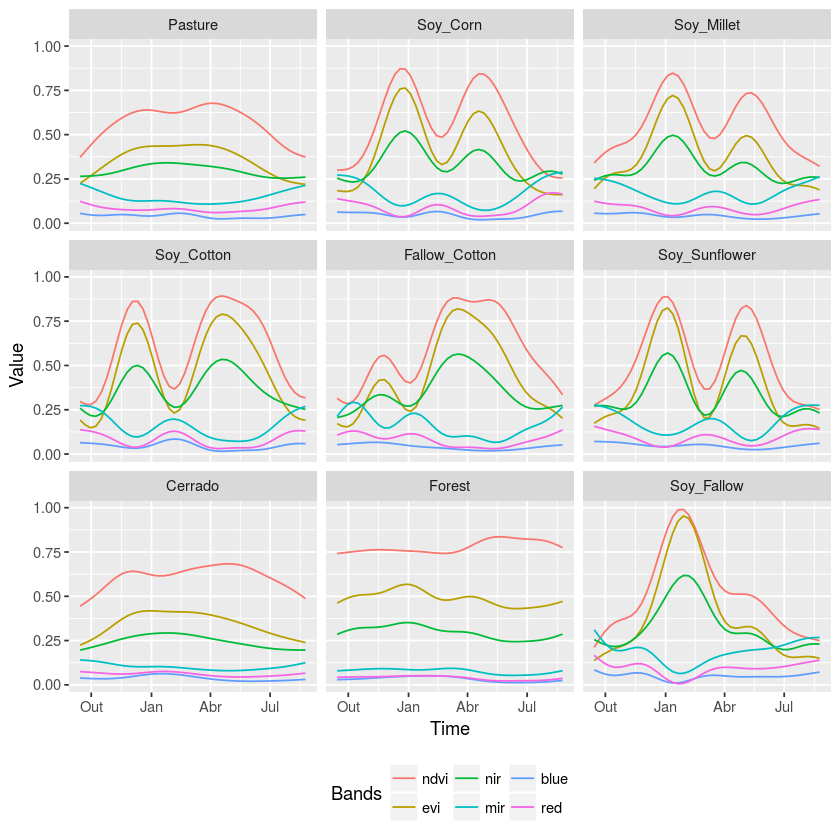

In [12]:
# obtain a set of land use patterns from the sample set using the GAM method
patterns.tb <- sits_patterns(embrapa_mt.tb)
sits_plot_patterns(patterns.tb)

## Shape matching between patterns and time series

The *Time Weight Dynamic Time Warpping (TWDTW)* algorithm measures the dissimilarity between land cover patterns and  time series. It is an adaptation of the DTW in which the warpping is weighted by time. The result is a set of dissimilarity measures which feed machine learning algorithms (such as Support Vector Machine, Random Forest, Neural Networks, etc.).

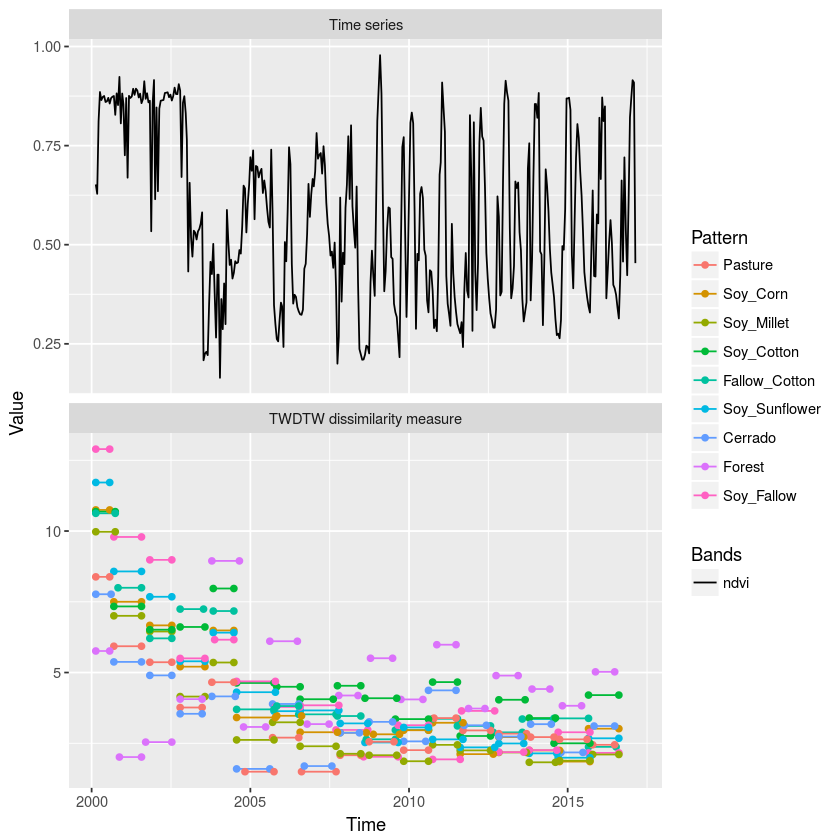

In [13]:
# find the matches between the patterns and the time series using the TWDTW algorithm
# (uses the dtwSat R package)
matches <- sits_TWDTW_matches(series.tb, patterns.tb, bands, alpha= -0.1, beta = 100, theta = 0.5, keep = TRUE)

# plot the alignments of the time series
sits_plot_TWDTW_alignments (matches)


## Classification
After a machine learning algorithm is trained, it can classify the land cover classes of the time series in the study area.

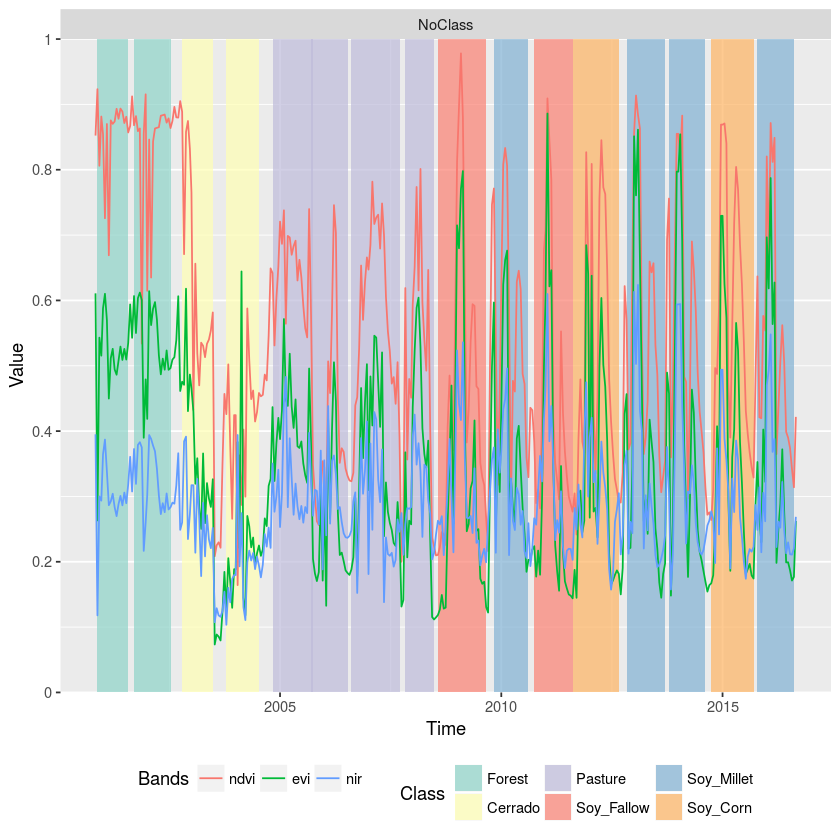

In [14]:
# classify the time series matches using yearly intervals
results.tb <- sits_TWDTW_classify(matches, series.tb, start_date = "2000-08-01", end_date = "2016-07-31",
                                  interval = "12 month")

# plot the classification of the time series by yearly intervals
sits_plot_TWDTW_classification (matches)

## Accuracy assessment
In our experiments of land use classification in Mato Grosso state we have performed a accuracy assement that indicates very good results.

<center>
<table align="center">
<tr>
<td>
<img src="img/accuracy.png" alt="Accuracy assessment" width=750> 
</td>
</tr>
</table>
</center>

## Mato Grosso Classification


<center>
<table align="center">
<tr>
<td>
<img src="img/classificaMT.png" alt="Mato Grosso classification" width=750> 
</td>
</tr>
</table>
</center>

## Reproducibilty

- Our code is hosted in a GitHub public repository: [github.com/e-sensing](https://github.com/e-sensing)
- For more information about the project, please go to [e-sensing.org](http://www.esensing.org/)

## Team


<center>
<table align="center">
<tr>
<td>
<img src="img/team.png" alt="e-Sensing Team" width=550> 
</td>
</tr>
</table>
</center>


## Take home message


- The e-Sensing project is building a platform for processing big geospatial data in order to help scientists to research land use and land cover change
- We are organizing decades of satellite images into cubes --- tridimensional space-time arrays ---- inside our platform
- We are working to find the best way to put together data and analysis
- We have been achieving very good results in land cover classification for large areas of Brazil
- Our platform is open source and it can be reproduced
- INPE is commited to maintain the EO datacube for the Brazilian biomes
<center>
<table align="center">
<tr>
<td>
<img src="img/th_message.png" alt="Take home message" width=550> 
</td>
</tr>
</table>
</center>
